In [ ]:
from torchdrug import datasets
from torchdrug.data.protein import Protein
from Bio import Align
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import networkx as nx
import random
from random import sample

# Datasest processing

In [2]:
dataset_loc = "A4_HUMAN_Seuma_2021.csv"
df = pd.read_csv(dataset_loc)
mutants = list(df['mutant'].values)
def get_mutations(list_mutants):
    mutations = []
    for i in list_mutants:
        mutations.extend(i.split(':'))
    return list(set(mutations))

x_train, x_test = train_test_split(mutants, test_size = 0.1, random_state = 42)
x_test, x_val = train_test_split(x_test, test_size = 0.5, random_state = 42)

train_mutations = get_mutations(x_train)
valid_mutations = get_mutations(x_val)
test_mutations = get_mutations(x_test)

# Cross-split overlap definition

In [3]:
def overlap(one, two, name):
    combined_mutations = list(set(one + two))

    num_overlap = sum([1 for i in one if i in two])
    print(f'{name} stats\t{num_overlap}/{len(combined_mutations)}, {num_overlap/len(combined_mutations)}')

overlap(test_mutations, train_mutations, 'test')

test stats	229/463, 0.4946004319654428


# Construct Spectral Property Graph

In [4]:
def create_graph(barcodes):
    G = nx.Graph()


    print("GOING TO INITIALIZE GRAPH")
    #Initialize Graph
    for barcode in barcodes:
        G.add_node(barcode)

    print("GRAPH INITIALIZED")

    #Now we create edges between nodes based on mutational overlap
    for bar_1 in tqdm(barcodes, total=len(barcodes)):
        for bar_2 in barcodes:
            if bar_1 != bar_2:
                for mut in bar_1.split(':'):
                    if mut in bar_2:
                        G.add_edge(bar_1, bar_2)
                        break

    return G

In [5]:
G = create_graph(mutants)

GOING TO INITIALIZE GRAPH
GRAPH INITIALIZED


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14483/14483 [01:29<00:00, 162.49it/s]


In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.number_connected_components(G))

14483
2139791
216


# Create SPECTRA splits

In [7]:
def run_independent_set(neighbor_lambda, input_G, tau_number, tau_mut, tau_degree, seed = None, debug=False, random_start = True):
    total_deleted = 0
    
    if seed is not None:
        random.seed(seed)
    
    G = input_G.copy()
    
    independent_set = []
    
    iterations = 0
    
    while not nx.is_empty(G):
        if not random_start:
            chosen_node = max(node_to_score, key=node_to_score.get)
        else:
            chosen_node = sample(list(G.nodes()), 1)[0]
        
        independent_set.append(chosen_node)
        neighbors = G.neighbors(chosen_node)
        neighbors_to_delete = []
        
        for neighbor in neighbors:
            if neighbor_lambda == 1.0:
                neighbors_to_delete.append(neighbor)
            elif neighbor_lambda != 0.0:
                if random.random() < neighbor_lambda:
                    neighbors_to_delete.append(neighbor)

        if debug:
            print(f"Iteration {iterations} Stats")
            print(f"Deleted {len(neighbors_to_delete)} nodes")
            
        for neighbor in neighbors_to_delete:
            G.remove_node(neighbor)
        
        if chosen_node not in neighbors_to_delete:
            G.remove_node(chosen_node)
    
        iterations += 1
    
    independent_set.append('NO_MUTATION')
    if debug:
        print(f"Total deleted {total_deleted}")
    return independent_set

In [8]:
def calculate_proportion(x_train, x_test):
 
    def flatten(l):
        return [item for sublist in l for item in sublist]
    
    
    one = flatten([i.split(':') for i in x_train])
    two = flatten([i.split(':') for i in x_test])
    
    combined_mutations = list(set(one + two))

    num_overlap = 0
    for i in combined_mutations:
        if i in one and i in two:
            num_overlap += 1
    
    return num_overlap/len(combined_mutations)

In [10]:
calculated_proportions = []
lambda_params = []
number_samples = []

for lambda_param in np.arange(0, 1.05, 0.025):
    lambda_params.append(lambda_param)
    result = run_independent_set(lambda_param, G, 0, 0, 0)
    x_train ,x_test = train_test_split(result,test_size=0.2) 
    proportion = calculate_proportion(x_train, x_test)
    calculated_proportions.append(proportion)
    number_samples.append(len(result))
    
    print(f"{lambda_param}\t{proportion}\t{len(result)}")
    result_file = open(f"amyloid_splits/lambda_{lambda_param}.txt", "w")
    result_file.write(f"{lambda_param}\t{proportion}\t{len(result)}\n")
    result_file.write(f"Train: {x_train}\n")
    result_file.write(f"Test: {x_test}\n")
    result_file.close()

0.0	0.5256410256410257	14469
0.025	0.5096359743040685	4450
0.05	0.47863247863247865	2994
0.07500000000000001	0.47629310344827586	2311
0.1	0.4606986899563319	1915
0.125	0.43383947939262474	1655
0.15000000000000002	0.4485776805251641	1478
0.17500000000000002	0.4184549356223176	1377
0.2	0.3905579399141631	1240
0.225	0.391304347826087	1157
0.25	0.3799126637554585	1063
0.275	0.3684210526315789	995
0.30000000000000004	0.37117903930131	938
0.325	0.3369330453563715	902
0.35000000000000003	0.3258426966292135	836
0.375	0.3065217391304348	826
0.4	0.33260393873085337	801
0.42500000000000004	0.31756756756756754	744
0.45	0.2873303167420814	706
0.47500000000000003	0.2782608695652174	712
0.5	0.29195402298850576	638
0.525	0.25	604
0.55	0.25057471264367814	605
0.5750000000000001	0.21967963386727687	575
0.6000000000000001	0.23326133909287258	607
0.625	0.2420091324200913	547
0.65	0.2191780821917808	536
0.675	0.2222222222222222	495
0.7000000000000001	0.18561484918793503	496
0.7250000000000001	0.19036697247

In [18]:
import pickle
pickle.dump(calculated_proportions, open('calc_prop', 'wb'))
pickle.dump(lambda_params, open('lambda_params', 'wb'))
pickle.dump(number_samples, open('number_samples', 'wb'))

# Plot results

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

lambda_params = pickle.load(open('lambda_params', 'rb'))
number_samples = pickle.load(open('number_samples', 'rb'))
calculated_proportions = pickle.load(open('calc_prop', 'rb'))

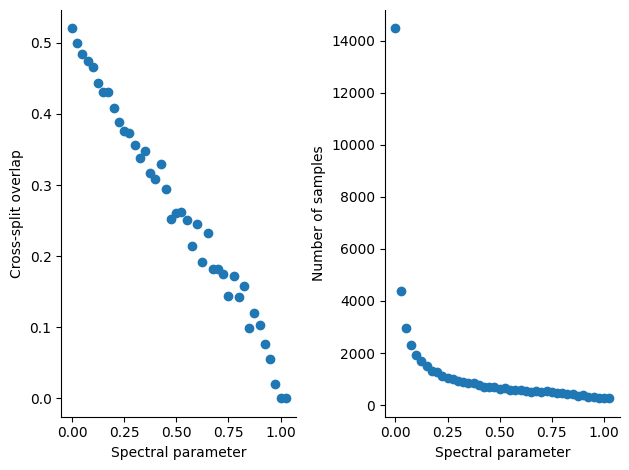

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.scatter(lambda_params, calculated_proportions)
ax1.set_ylabel('Cross-split overlap')
ax1.set_xlabel('Spectral parameter')
ax1.spines[['right', 'top']].set_visible(False)
ax2.scatter(lambda_params, number_samples)
ax2.set_ylabel('Number of samples')
ax2.set_xlabel('Spectral parameter')
ax2.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('ProteinGym_Amyloid_Stats.pdf')

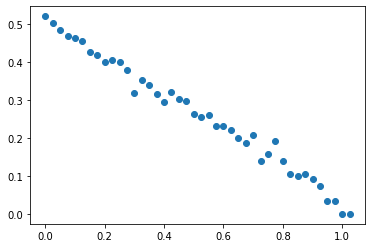

In [31]:
plt.scatter(lambda_params, calculated_proportions)

In [32]:
def find_closest(overlap, x, y):
    min_difference = 1000000
    best_overlap = None
    best_param = None
    
    
    for i,j in zip(x, y):
        if abs(overlap - j) < min_difference:
            best_param = i
            best_overlap = j
            min_difference = abs(overlap - j)
    
    print(f"{best_overlap} and {best_param} for {overlap}")

In [33]:
find_closest(0.5, lambda_params, calculated_proportions)

0.5031982942430704 and 0.025 for 0.5
